### URL for getting RAW data from Github

In [237]:
!pip install pyspark

In [238]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
from pyspark.sql import functions as fn
import pyspark.sql.functions as f
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as Row
import matplotlib.pyplot as plt
import pandas as pd

MAX_MEMORY = "12g"

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", MAX_MEMORY) \
  .config("spark.driver.memory", MAX_MEMORY)\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size",MAX_MEMORY)\
  .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [239]:
before_url = "https://raw.githubusercontent.com/pratt-datar/IST_718/main/tweets.csv"

after_url = "https://raw.githubusercontent.com/pratt-datar/IST_718/main/tweet_after.csv"

In [240]:
# Data extraction in pandas dataframe
before_df = pd.read_csv(before_url)
after_df = pd.read_csv(after_url)

In [241]:
# Pandas to Spark
from pyspark.sql.types import *

mySchema = StructType([StructField("user", StringType())\
                      ,StructField("id", FloatType())\
                      ,StructField("location", StringType())\
                      ,StructField("date", IntegerType())\
                      ,StructField("favourites_count", StringType())\
                      ,StructField("text", StringType())\
                      ,StructField("retweet", StringType())])
df_before = spark.createDataFrame(before_df,schema=mySchema)

In [242]:
# Dropping ID, Date, Favorites count column, removing retweeted tweets and dropping duplicates 
df_before = df_before.drop('id', 'date', 'favourites_count', 'location').filter(df_before['retweet'] == 'false').dropDuplicates().drop('retweet')

In [243]:
# Creating pandas dataframe to create user level aggregation
before_df = df_before.toPandas()

In [244]:
before_df

,user,text
0,AmandaCaponi,Poor #MelaniaTrump @FLOTUS #JoeBiden #DonaldTr...
1,ValdaDeDieu,@RepDougCollins @realDonaldTrump Oh the contor...
2,RobHNY,"@TheRickWilson Yes, but kind of cool that #Don..."
3,YAHsJUDGEMENT,Well @SpeakerPelosi I see that you are going t...
4,NH_India,#DonaldTrump's handling of the #coronavirus pa...
...,...,...
21555,americanmishima,@joncoopertweets We’ll all sleep better with J...
21556,clairecount,"But a conservative's ""choice between the arson..."
21557,Rhaegaro,In 18 days Donald Trump will only be the Presi...
21558,carrisa_grace,@benwikler I’m praying for my home state WI to...


#### Users with most tweets

In [245]:
users = before_df.groupby('user').count().reset_index()

In [246]:
# It would be interesting to categorize these users as Pro-Trump or Pro-Biden. Some of the user are small journalism parties
users[users['text'] > 40]

,user,text
394,AgassizObserver,81
3553,Hotpage_News,102
7730,StatesPoll,48
7933,THCPetDoctor,60
10582,derekdob,42
12813,mcleod,70
13782,quirkynoname,43


### Creating user level aggregation for text column

In [247]:
before_df['text'] = before_df.groupby('user')['text'].transform(lambda x: ' + '.join(x))

In [248]:
before_df = before_df.drop_duplicates()

In [249]:
before_df

,user,text
0,AmandaCaponi,Poor #MelaniaTrump @FLOTUS #JoeBiden #DonaldTr...
1,ValdaDeDieu,@RepDougCollins @realDonaldTrump Oh the contor...
2,RobHNY,"@TheRickWilson Yes, but kind of cool that #Don..."
3,YAHsJUDGEMENT,Well @SpeakerPelosi I see that you are going t...
4,NH_India,#DonaldTrump's handling of the #coronavirus pa...
...,...,...
21554,Namaste3464_II,"@mercedesschlapp @JoeBiden @ABCPolitics Me, ru..."
21555,americanmishima,@joncoopertweets We’ll all sleep better with J...
21557,Rhaegaro,In 18 days Donald Trump will only be the Presi...
21558,carrisa_grace,@benwikler I’m praying for my home state WI to...


### Generating hashtags

In [250]:
mySchema = StructType([StructField("user", StringType())\
                      ,StructField("text", StringType())])
df_before = spark.createDataFrame(before_df,schema=mySchema)

In [251]:
# extract the hashtags
import re
#extracting hashtags as a means of possible cluster validation  
def extraxt_hashtags(text):
  hashtags = re.findall(r'\B#\w*[a-zA-Z]+\w*', text)
  return hashtags

In [252]:
from pyspark.sql.functions import udf, expr, concat, col
from pyspark.sql import types

func_hash = udf(extraxt_hashtags, types.StringType())
df_before = df_before.withColumn("hashtags", func_hash("text"))

### Cleaning text

In [253]:
# clean tweet
from string import punctuation
def clean_tweet(tweet):
    # Remove hyperlinks
    tweet = re.sub("https?://[A-Za-z0-9./]*","",tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    #@user -> at_user
    tweet = re.sub("@[\w]*","",tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words: I, a , am, me (2 or less letters)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove emojis or other. special characters
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

In [254]:
func_clean = udf(clean_tweet, types.StringType())

# Final cleaned dataframe
df_before = df_before.withColumn("clean_text", func_clean("text"))

In [255]:
df_before.show()

+--------------+--------------------+--------------------+--------------------+
|          user|                text|            hashtags|          clean_text|
+--------------+--------------------+--------------------+--------------------+
|  AmandaCaponi|Poor #MelaniaTrum...|[#MelaniaTrump, #...|               poor |
|   ValdaDeDieu|@RepDougCollins @...|      [#DonaldTrump]|the contortions y...|
|        RobHNY|@TheRickWilson Ye...|[#DonaldTrump, #T...|yes but kind cool...|
| YAHsJUDGEMENT|Well @SpeakerPelo...|[#DonaldTrump, #S...|well see that you...|
|      NH_India|#DonaldTrump's ha...|[#DonaldTrump, #c...|handling the pand...|
|    Elsa050467|@nypost Of course...|      [#DonaldTrump]|course does ‍♀️ b...|
|       IAMBMRD|Yes, #America, pl...|[#America, #SaveT...|yes please the re...|
| MarkBurnettLD|If #DonaldTrump l...|[#DonaldTrump, #E...|loses who would t...|
|  ABC7Amarillo|President Donald ...|                  []|president donald ...|
| BorisDirnbach|@ZemanLynnZ @Dona...|   

In [256]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import IDF
import requests
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer

In [272]:
# getting the stop words list from the URL
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

# Tokenizer stage where sentences would be converted to words
tokenizer = Tokenizer()\
  .setInputCol("clean_text")\
  .setOutputCol("words")

# Stop words filter stage would remove the common occuring words that have no information value
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

# Introducding a count vectorizer what counts the frequency of words in a document and outputs a vector
cv = CountVectorizer()\
  .setInputCol("filtered")\
  .setOutputCol("tf")

# Introducing a Inverse document frequency stage which in combination would give TF-IDF that gives less importance of occurence of non-stop words throughout most of the documents
# And assigns more importance to words that are less frequent
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

# standardize features
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='tfidf', outputCol='centered_tfidf')

# PCA
components = 2
pca = feature.PCA(k=components, inputCol='centered_tfidf', outputCol='scores')

# Creating a pipeline
pipe_pca_before = Pipeline(stages=[tokenizer, sw_filter, cv, idf, center, pca])

In [ ]:
# Fitting the pipeline
model_before = pipe_pca_before.fit(df_before)

# Creating a new transformed dataframe
pca_before = model_before.transform(df_before)

In [ ]:
pca_before.show()

In [ ]:
print("Shape of the TFIDF data {} x {}".format(pca_before.count(), len(model_before.stages[-4].vocabulary)))

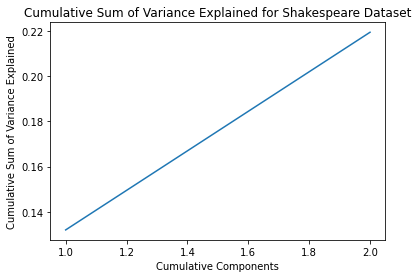

In [235]:
# your code here
explained_var = model_before.stages[-1].explainedVariance
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Cumulative Sum of Variance Explained for Shakespeare Dataset")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")
plt.show()

In [195]:
# PC1 Loading coefficients
pc1 = list(map(abs, model_before.stages[-1].pc.toArray()[:, 0].tolist()))

# Vocabulary
vocabulary = model_before.stages[2].vocabulary

pc_loadings = pd.DataFrame([vocabulary, pc1]).T.rename(columns={0: 'word', 1: 'load_pc1'}).sort_values('load_pc1')

In [197]:
pc_loadings.tail(10)

,word,load_pc1
403,bye,0.142533
28,new,0.146994
848,added,0.148456
131,poll,0.155868
385,info,0.160115
261,yesterday,0.172657
470,average,0.19668
24,2020,0.344545
1,trump,0.461922
0,biden,0.612809


In [198]:
pc_loadings.head(10)

,word,load_pc1
1455,fascist,0
1947,grasp,0
1948,finding,0
1949,impeach,0
1950,writes,0
1951,web,0
1952,sentences,0
1953,reasonable,0
1954,streaming,0
1955,margin,0


In [199]:
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='scores', outputCol='centered_scores')
norm = feature.Normalizer(inputCol="centered_scores", outputCol="norm_scores", p=2.0)

kmeans = clustering.KMeans(k=2, featuresCol='norm_scores', predictionCol= 'kmeans')

# Creating a pipeline
pipe_pca_kmeans_before = Pipeline(stages=[center, norm, kmeans])

# Fitting and transforming the pipeline on the chars_pca_df 
pipeline_model = pipe_pca_kmeans_before.fit(pca_before)

pca_before = pipeline_model.transform(pca_before)

In [200]:
# Creating a list of user_names
user_names = np.array(pca_before.select('user').rdd.map(lambda x: x['user']).collect())

# Creating a list of scores 
scores = np.array(pca_before.select('scores').rdd.map(lambda x: x['scores']).collect())

kmeans_cluster = np.array(pca_before.select('kmeans').rdd.map(lambda x: x['kmeans']).collect())

df_viz = pd.DataFrame({'PC1': scores[:,0], 'PC2': scores[:,1], 'user': user_names, 'kmean_cls': kmeans_cluster})

In [202]:
import plotly.express as px

In [203]:
fig = px.scatter(df_viz, x='PC1', y='PC2', color="kmean_cls", template = 'plotly_dark', hover_data= ['user'], title= 'PCA with K-means')
fig.update_traces(textposition='top center')
fig.show()